## Library

Load all the needed library. <br>
<u>Needed library</u> : numpy, matplotlib, pandas, tensorflow, skopt, keras, sklearn

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import json
import tensorflow as tf
import statistics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

from sklearn.metrics import r2_score

## Function

In this study, parameter below are studied:

| Parameter | Value | Notes |
|:---------|:------------:|:--------------|
| Learning rate | 10$^{-6}$-10$^{-2}$ | Learning rate of the optimizer function |
| Number of layers | 1 - 3 | Number of hidden layer | 
| Number of neurons | 2 - 20 | Number of nodes in each hidden layer | 
| Activation function | Relu | Activation function on each nodes | 
| Optimizer | Adam | Function to optimize the NN | 
| Batch size | 64 | Data points that pass through NN every step | 
| Dropout | - | Proobability where nodes are randomly disconected during training | 
| Epoch | 100 | Amount of times to go through our training data |


In [2]:
# Model definition
def ANN_model(features, target, learn_rate, layers, nodes):
    """
    Input Data:
    features   : Input data for the ANN (numpy array)
    target     : Output of the ANN (numpy array)
    learn_rate : Learning-rate for the optimizer.
    layers     : Number of dense layers.
    nodes      : Number of nodes in each dense layer.
    """
        
    # Define model
    model = Sequential()
    if layers == 1:
        # Input layer
        model.add(Dense(nodes, activation='relu', 
                       input_dim=features.shape[1]))      
    else:
        model.add(Dense(nodes, activation='relu', 
                       input_dim=features.shape[1]))
        for i in range(layers-1):
            model.add(Dense(nodes, activation='relu'))

    # Add output layer, 1 nodes
    model.add(Dense(1, activation='linear'))

    adam = Adam(lr=learn_rate)
    model.compile(optimizer=adam, loss='mse',
                  metrics=['mean_absolute_percentage_error',
                           'RootMeanSquaredError'])
    
    return model

In [3]:
# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=5, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

# Function
@use_named_args(dimensions=dimensions)
def ANN_study(learn_rate, layers, nodes):
    """
    Hyper-parameters:
    features    : Input of the ANN (np.array)
    target      : Output of the ANN (np.array)
    val_features: Input of the ANN for validation (np.array)
    val_target  : Output of the ANN for validation (np.array)
    learn_rate  : Learning-rate for the optimizer.
    layers      : Number of dense layers.
    nodes       : Number of nodes in each dense layer.
    activation  : Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('Learning rate: {0:.1e}'.format(learn_rate))
    print('Dense layers:', layers)
    print('Nodes:', nodes)
    
    model = ANN_model(features=features, 
                         target=target,
                         learn_rate=learn_rate,
                         layers=layers,
                         nodes=nodes)

    # Use Keras to train the model.
    patience = 20
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, 
                       patience=patience, restore_best_weights=True)
    history = model.fit(features, target, verbose=0, epochs=num_epochs, batch_size = 64,
                    validation_data=(val_features, val_target), callbacks=[es])

    # Get the regression validation loss
    # after the last training-epoch.
    if es.stopped_epoch == 0:
        loss = history.history['loss'][-1]
    else:
        loss = history.history['loss'][es.stopped_epoch-patience]

    # Print the validation loss.
    print()
    print('loss:', loss)
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_loss

    # If the validation loss of the saved model is improved ...
    if loss < best_loss:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the regression accuracy.
        best_loss = loss
        
        #save the history of the best model
        ANN_performance = history.history
        temp = json.dumps(ANN_performance)
        f = open(path_best_model_performance,"w")
        f.write(temp)
        f.close()

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization
    return loss

## Result Plot
Here, functions and plots that used to assess the robustness for each proxy segments is written.

In [4]:
# function for Error and Accuracy of the ANN
def plot_error_acc(history):
    # history = Fitted ANN model to our dataset

    # Loss Function Plot
    plt.figure(1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.legend()
    plt.grid(True)

    # MAPE Plot
    plt.figure(2)
    plt.plot(history['mean_absolute_percentage_error'], label='Training')
    plt.plot(history['val_mean_absolute_percentage_error'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE (%)')
    plt.ylim([0, 50])
    plt.legend()
    plt.grid(True)

    # RMSE Plot
    plt.figure(3)
    plt.plot(history['root_mean_squared_error'], label='Training')
    plt.plot(history['val_root_mean_squared_error'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

# Error distribution and proxy performance function for test data
def plot_train_performance(model, train_input, train_output, val_input, val_output, lims):
    # model = the ANN model (fitted)
    # train_input = input for the ANN from training database
    # train_output = output of the training database
    # val_input = input for the ANN from validation database
    # val_output = output of the validation database
    # lims = 2 points [min,max] for the plot boundary

    # Calculate test data with the model
    train_predictions = model.predict(train_input).flatten()
    val_predictions = model.predict(val_input).flatten()

    # Checking performance of test data
    plt.figure(4)
    plt.axes(aspect='equal')
    plt.scatter(train_output, train_predictions, label='Training')
    plt.scatter(val_output, val_predictions, label='Validation', marker='x')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    # Getting error distribution
    plt.figure(5)
    error_train = train_predictions - train_output
    error_val = val_predictions - val_output
    plt.hist(error_train, bins=25)
    plt.hist(error_val, bins=25)
    plt.xlabel('Prediction Error [Error]')
    _ = plt.ylabel('Count')
    
    # Calculate R^2
    r2_train = r2_score(train_output, train_predictions)
    r2_val = r2_score(val_output, val_predictions)
    print("R-square Training: {:.6f}".format(r2_train))
    print("R-square Validation: {:.6f}".format(r2_val))
    
    # Calculate Training Absolute Error (AE)
    ape_train = abs(train_output-train_predictions)
    max_ape_train = max(ape_train)
    mean_ape_train = statistics.mean(ape_train)
    min_ape_train = min(ape_train)
    print("""Training Average Absolute Error:
    - Maximum=%.6f
    - Mean=%.6f
    - Minimum=%.6f""" % (max_ape_train, mean_ape_train, min_ape_train))
    
    # Calculate Validation Absolute Error (AE)
    ape_val = abs(val_output-val_predictions)
    max_ape_val = max(ape_val)
    mean_ape_val = statistics.mean(ape_val)
    min_ape_val = min(ape_val)
    print("""Validation Average Absolute Error:
    - Maximum=%.6f
    - Mean=%.6f
    - Minimum=%.6f""" % (max_ape_val, mean_ape_val, min_ape_val))

# Error distribution and proxy performance function for test data
def plot_test_performance(model, test_input, test_output,lims):
    # model = the ANN model (fitted)
    # test_input = input for the ANN from test database
    # test_output = output of the test database
    # lims = 2 points [min,max] for the plot boundary

    # Calculate test data with the model
    test_predictions = model.predict(test_input).flatten()

    # Checking performance of test data
    plt.figure(6)
    plt.axes(aspect='equal')
    plt.scatter(test_output, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    # Getting error distribution
    plt.figure(7)
    error = test_predictions - test_output
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Error]')
    _ = plt.ylabel('Count')
    
    # Calculate R^2
    r2_test = r2_score(test_output, test_predictions)
    print("R-square Test: {:.6f}".format(r2_test))
    
    # Calculate Absolute Error (APE)
    ape_test = abs(test_output-test_predictions)
    max_ape_test = max(ape_test)
    mean_ape_test = statistics.mean(ape_test)
    min_ape_test = min(ape_test)
    print("""Average Absolute Error:
    - Maximum=%.6f
    - Mean=%.6f
    - Minimum=%.6f""" % (max_ape_test, mean_ape_test, min_ape_test))

## Input data
Upload the data that obtained from Eclipse. Data separated into 75:25 for training and validation. It is randomized with seed=10 for reproducibility. We forced the edge of LHS to be used as training set

In [5]:
# Importing database
field_proxy_database = pd.read_excel('EggModel.xlsx')

In [6]:
# Making new copy of database
main_database = field_proxy_database.copy()

# Sampling based on cases number, seed (10) for reproducible result
train_percent = 0.75
val_percent = 0.25
# test = 0.15

solutionspace=3
train = train_percent * max(main_database['Case'])-2**solutionspace

# Not to include solution space edge to validation
num_cases = np.arange(1, max(main_database['Case'])+1-2**solutionspace)
np.random.seed(10)
np.random.shuffle(num_cases)
train_case, val_case = np.split(num_cases, [int(train)])
train_case = np.append(train_case,[61, 62, 63, 64, 65, 66, 67, 68])

# Labeling database based on training, validation, test cases
main_database['Identifier'] = main_database['Case'].apply(lambda x: 'Train' if x in train_case else 'Validation')

In [7]:
def ANNdataset (main_database, input_set, output_set):    
    train_dataset = main_database[main_database['Identifier'] == 'Train']
    val_dataset = main_database[main_database['Identifier'] == 'Validation']
    
    unneeded_columns = main_database.columns.tolist()
    
    for x in input_set:
        unneeded_columns.remove(x)
        
    unneeded_columns.remove(output_set)

    train_dataset = train_dataset.drop(unneeded_columns, axis=1)
    val_dataset = val_dataset.drop(unneeded_columns, axis=1)
    
    train_label = train_dataset.pop(output_set).to_numpy()
    train_features = train_dataset.to_numpy()

    val_label = val_dataset.pop(output_set).to_numpy()
    val_features = val_dataset.to_numpy()
    return train_features, train_label, val_features, val_label

In [8]:
gas_database = main_database[main_database['FGIR [sm3/d]'] >= 1]
water_database = main_database[main_database['FGIR [sm3/d]'] < 1]

input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FOPR (t-1)']
output_set = 'FOPR [sm3/d]'
FOPR_FgTf, FOPR_FgTl, FOPR_FgVf, FOPR_FgVl = ANNdataset(gas_database, input_set, output_set)
FOPR_FwTf, FOPR_FwTl, FOPR_FwVf, FOPR_FwVl = ANNdataset(water_database, input_set, output_set)
    
# CO2 database
for i in range(0, 3):
    if i==0:
        time_database = main_database[main_database['RealTimestep'] <= 360]
        
        input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FCO2PR (t-1)']
        output_set = 'FCO2PR [kg-mole/d]'
        CO2_F1Tf, CO2_F1Tl, CO2_F1Vf, CO2_F1Vl = ANNdataset(time_database, input_set, output_set)
    
    elif i==1:
        time_database = main_database[main_database['RealTimestep'] > 360]
        time_database = time_database[time_database['RealTimestep'] <= 5*360]

        gas_database = time_database[time_database['FGIR [sm3/d]'] >= 1]
        water_database = time_database[time_database['FGIR [sm3/d]'] < 1]

        input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FCO2PR (t-1)']
        output_set = 'FCO2PR [kg-mole/d]'
        CO2_FgTf, CO2_FgTl, CO2_FgVf, CO2_FgVl = ANNdataset(gas_database, input_set, output_set)
        CO2_FwTf, CO2_FwTl, CO2_FwVf, CO2_FwVl = ANNdataset(water_database, input_set, output_set)
        
    else:
        time_database = main_database[main_database['RealTimestep'] > 5*360]

        gas_database = time_database[time_database['FGIR [sm3/d]'] >= 1]
        water_database = time_database[time_database['FGIR [sm3/d]'] < 1]

        input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FCO2PR (t-1)']
        output_set = 'FCO2PR [kg-mole/d]'
        CO2_FgTf2, CO2_FgTl2, CO2_FgVf2, CO2_FgVl2 = ANNdataset(gas_database, input_set, output_set)
        CO2_FwTf2, CO2_FwTl2, CO2_FwVf2, CO2_FwVl2 = ANNdataset(water_database, input_set, output_set)

## Proxy Development
### FOPR - Gas injection phase
The main study is to develop a proxy as a subtitute for the current study that being done. <br>
The proxy below is for gas injection phase of WAG cycle.

In [9]:
# Initialization before hyperparameter study
path_best_model = 'FOPR_gas_proxy.keras'
path_best_model_performance = 'FOPR_gas_proxy_performance.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = FOPR_FgTf, FOPR_FgTl, FOPR_FgVf, FOPR_FgVl

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=2, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 2, 5]

In [10]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate = %.6f
- number of hidden layers = %d
- number of nodes = %d
- best loss = %.6f""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2], best_loss))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 2
Nodes: 5

loss: 0.012666115537285805

Learning rate: 1.0e-03
Dense layers: 2
Nodes: 18

loss: 0.00019685486040543765

Learning rate: 2.0e-05
Dense layers: 2
Nodes: 9

loss: 0.002944663632661104

Learning rate: 2.4e-06
Dense layers: 3
Nodes: 5

loss: 0.13102449476718903

Learning rate: 3.4e-05
Dense layers: 3
Nodes: 20

loss: 0.0011066311271861196

Learning rate: 6.7e-05
Dense layers: 3
Nodes: 7

loss: 0.0018315507331863046

Learning rate: 2.5e-04
Dense layers: 3
Nodes: 12

loss: 0.0002413241018075496

Learning rate: 2.3e-04
Dense layers: 2
Nodes: 8

loss: 0.0007352664251811802

Learning rate: 2.1e-06
Dense layers: 2
Nodes: 8

loss: 0.023506907746195793

Learning rate: 1.2e-03
Dense layers: 2
Nodes: 10

loss: 0.00022172204626258463

Learning rate: 1.8e-05
Dense layers: 3
Nodes: 8

loss: 0.010478687472641468

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 19

loss: 0.000155854708282277

Learning rate: 1.0e-02
Dense layers: 2
Nodes: 20
Restoring model

C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 2
Nodes: 20

loss: 0.00016228437016252428



C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 2
Nodes: 20

loss: 0.0001587673759786412



C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 2
Nodes: 20

loss: 0.00015273426834028214

Learning rate: 4.3e-03
Dense layers: 2
Nodes: 20

loss: 0.00016211603360716254

Learning rate: 1.0e-06
Dense layers: 2
Nodes: 19

loss: 0.06730174273252487

Learning rate: 4.5e-04
Dense layers: 2
Nodes: 2

loss: 0.005827377550303936

Learning rate: 9.3e-04
Dense layers: 3
Nodes: 20

loss: 0.0001953898317879066

Learning rate: 1.2e-04
Dense layers: 2
Nodes: 3

loss: 0.01295285765081644

Learning rate: 4.0e-05
Dense layers: 2
Nodes: 20

loss: 0.0008841805392876267

Learning rate: 2.8e-04
Dense layers: 2
Nodes: 20

loss: 0.00042517113615758717

Learning rate: 1.0e-06
Dense layers: 3
Nodes: 2

loss: 0.12704609334468842

Learning rate: 4.3e-05
Dense layers: 2
Nodes: 20

loss: 0.0010029228869825602

Learning rate: 1.3e-04
Dense layers: 3
Nodes: 20

loss: 0.00032461321097798645

Learning rate: 4.3e-06
Dense layers: 2
Nodes: 18

loss: 0.07144592702388763

Learning rate: 2.5e-03
Dense layers: 2
Nodes: 17

loss: 0.00

C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 2
Nodes: 2

loss: 0.0007802004693076015

Learning rate: 1.5e-04
Dense layers: 2
Nodes: 20

loss: 0.00037205283297225833

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 2
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping

loss: 0.0014388412237167358

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 10
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping

loss: 0.00021085303160361946

Learning rate: 8.9e-05
Dense layers: 2
Nodes: 13

loss: 0.0008780809585005045

Learning rate: 4.7e-05
Dense layers: 3
Nodes: 20

loss: 0.0007057394250296056

Learning rate: 5.1e-04
Dense layers: 3
Nodes: 20

loss: 0.00016014499124139547



C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 2
Nodes: 2
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping

loss: 0.0014626062475144863

Learning rate: 9.1e-05
Dense layers: 2
Nodes: 12

loss: 0.0010837955633178353

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 11

loss: 0.0001904868258861825

Learning rate: 3.4e-05
Dense layers: 2
Nodes: 20

loss: 0.0011992411455139518

Learning rate: 1.0e-02
Dense layers: 2
Nodes: 13
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping

loss: 0.00016168691217899323

Learning rate: 1.8e-06
Dense layers: 2
Nodes: 20

loss: 0.08578623831272125

Learning rate: 2.4e-03
Dense layers: 2
Nodes: 3
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping

loss: 0.0013960772193968296

Learning rate: 1.0e-02
Dense layers: 2
Nodes: 18

loss: 0.00017583713633939624

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 8

loss: 0.0002462194242980331

Learning rate: 1.0e-02
Dense layers: 3
N

In [11]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.994142
R-square Validation: 0.986596
Training Average Absolute Error:
    - Maximum=0.055550
    - Mean=0.005513
    - Minimum=0.000002
Validation Average Absolute Error:
    - Maximum=0.076778
    - Mean=0.008087
    - Minimum=0.000002


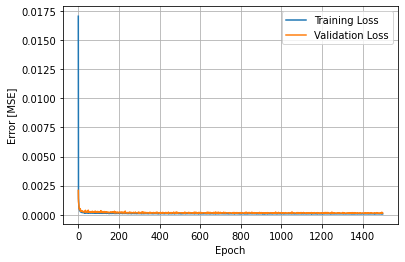

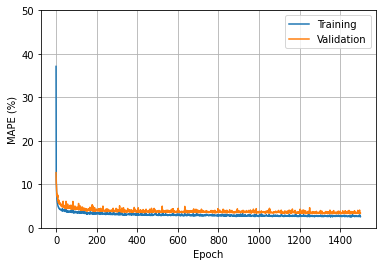

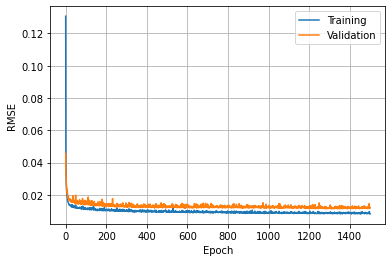

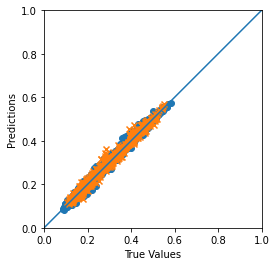

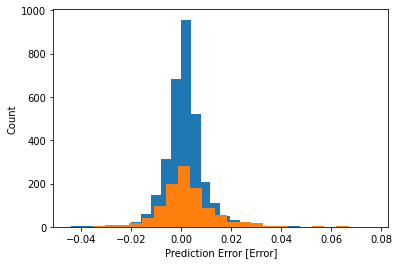

In [10]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

### FOPR - Water injection phase proxy

In [11]:
# Initialization before hyperparameter study
path_best_model = 'FOPR_wat_proxy.keras'
path_best_model_performance = 'FOPR_wat_proxy_performance.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = FOPR_FwTf, FOPR_FwTl, FOPR_FwVf, FOPR_FwVl

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=2, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 2, 5]

In [14]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate=%.6f
- number of hidden layers=%d
- number of nodes=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2]))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 2
Nodes: 5

loss: 0.7379613518714905

Learning rate: 1.9e-04
Dense layers: 3
Nodes: 16

loss: 0.000716507202014327

Learning rate: 1.6e-04
Dense layers: 3
Nodes: 13

loss: 0.0011132872896268964

Learning rate: 6.7e-06
Dense layers: 3
Nodes: 5

loss: 0.11161880195140839

Learning rate: 7.2e-04
Dense layers: 2
Nodes: 6

loss: 0.0025416139978915453

Learning rate: 3.7e-03
Dense layers: 3
Nodes: 8

loss: 0.0007094663451425731

Learning rate: 1.3e-03
Dense layers: 2
Nodes: 18

loss: 0.0004612208576872945

Learning rate: 2.1e-03
Dense layers: 3
Nodes: 7

loss: 0.0006890091462992132

Learning rate: 7.0e-06
Dense layers: 2
Nodes: 2

loss: 0.16027788817882538

Learning rate: 3.9e-05
Dense layers: 3
Nodes: 18

loss: 0.0023219939321279526

Learning rate: 3.3e-05
Dense layers: 2
Nodes: 11

loss: 0.005478049628436565

Learning rate: 4.5e-06
Dense layers: 2
Nodes: 4

loss: 0.1388895958662033

Learning rate: 4.3e-04
Dense layers: 2
Nodes: 9

loss: 0.00219971546903

In [15]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.994542
R-square Validation: 0.986941
Training Average Absolute Error:
    - Maximum=0.128967
    - Mean=0.009264
    - Minimum=0.000005
Validation Average Absolute Error:
    - Maximum=0.087447
    - Mean=0.013678
    - Minimum=0.000017


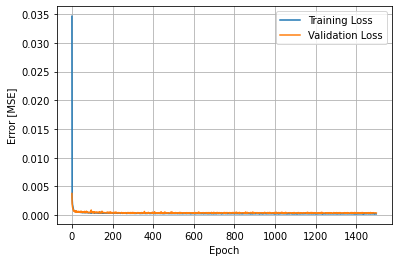

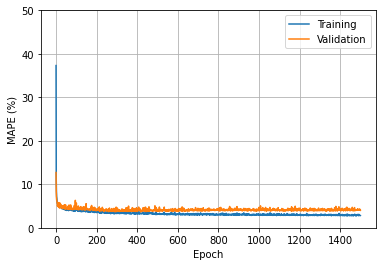

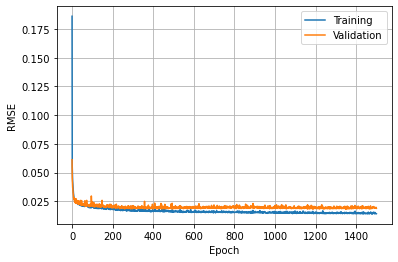

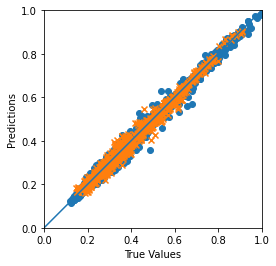

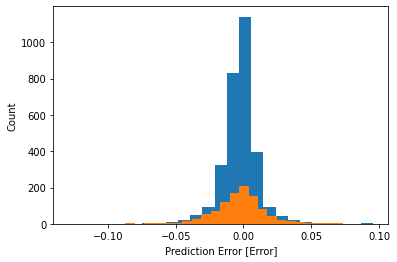

In [12]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

# CO2 Proxy

### 1st year proxy

In [13]:
# Initialization before hyperparameter study
path_best_model = 'CO2_1_proxy.keras'
path_best_model_performance = 'CO2_1_proxy_performance.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = CO2_F1Tf, CO2_F1Tl, CO2_F1Vf, CO2_F1Vl

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 1, 5]

In [18]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate=%.6f
- number of hidden layers=%d
- number of nodes=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2]))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 1
Nodes: 5

loss: 0.06804101169109344

Learning rate: 2.0e-04
Dense layers: 1
Nodes: 6

loss: 0.002019750652834773

Learning rate: 1.2e-06
Dense layers: 1
Nodes: 10

loss: 0.005811830051243305

Learning rate: 5.4e-03
Dense layers: 2
Nodes: 14

loss: 0.00011206732597202063

Learning rate: 1.0e-06
Dense layers: 2
Nodes: 13

loss: 0.03714073821902275

Learning rate: 1.0e-06
Dense layers: 2
Nodes: 11

loss: 0.0006909717922098935

Learning rate: 4.3e-03
Dense layers: 3
Nodes: 16

loss: 5.287841850076802e-05

Learning rate: 1.4e-05
Dense layers: 1
Nodes: 5

loss: 0.004416756331920624

Learning rate: 1.6e-03
Dense layers: 1
Nodes: 11

loss: 0.0003047930367756635

Learning rate: 2.5e-05
Dense layers: 2
Nodes: 13

loss: 0.05172523856163025

Learning rate: 1.8e-06
Dense layers: 2
Nodes: 11

loss: 0.038167234510183334

Learning rate: 1.0e-02
Dense layers: 2
Nodes: 5

loss: 6.781568663427606e-05

Learning rate: 1.4e-03
Dense layers: 3
Nodes: 4

loss: 0.00045464

C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 1
Nodes: 18

loss: 9.002312435768545e-05

Learning rate: 1.1e-06
Dense layers: 1
Nodes: 10

loss: 0.08205240964889526

Learning rate: 1.4e-06
Dense layers: 1
Nodes: 10

loss: 0.05933476239442825

Learning rate: 4.8e-03
Dense layers: 3
Nodes: 16

loss: 8.88716967892833e-05

Learning rate: 4.6e-03
Dense layers: 1
Nodes: 16

loss: 0.00012707884889096022

Learning rate: 8.9e-03
Dense layers: 2
Nodes: 5

loss: 0.00020980018598493189

Learning rate: 8.9e-03
Dense layers: 3
Nodes: 18
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping

loss: 1.8001386706600897e-05

Learning rate: 1.1e-03
Dense layers: 2
Nodes: 20

loss: 0.0001531940943095833

Learning rate: 4.8e-03
Dense layers: 2
Nodes: 14

loss: 0.00012332286860328168

Learning rate: 1.8e-03
Dense layers: 3
Nodes: 11

loss: 0.00012612475256901234

Learning rate: 1.3e-03
Dense layers: 2
Nodes: 4
Restoring model weights from the end of the best epoch.
Epoch 00090: early stop

C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-06
Dense layers: 2
Nodes: 11

loss: 0.0073613389395177364

Learning rate: 9.3e-03
Dense layers: 3
Nodes: 3

loss: 0.00040704457205720246

Learning rate: 1.7e-03
Dense layers: 2
Nodes: 9

loss: 0.00011726126831490546

Learning rate: 1.4e-03
Dense layers: 2
Nodes: 6

loss: 0.0003626335528679192

Learning rate: 1.2e-03
Dense layers: 2
Nodes: 14

loss: 0.00024270972062367946

Learning rate: 1.4e-03
Dense layers: 2
Nodes: 15

loss: 0.0001324472250416875

Learning rate: 1.2e-03
Dense layers: 2
Nodes: 17

loss: 0.00014964347064960748

Learning rate: 1.0e-06
Dense layers: 2
Nodes: 8

loss: 0.8020336627960205

Learning rate: 2.2e-05
Dense layers: 1
Nodes: 5

loss: 0.03947246074676514

Learning rate: 2.1e-03
Dense layers: 2
Nodes: 13

loss: 0.00014785942039452493

Learning rate: 2.5e-03
Dense layers: 1
Nodes: 15

loss: 0.00012897176202386618

Learning rate: 2.2e-03
Dense layers: 3
Nodes: 17

loss: 6.525685603264719e-05

Learning rate: 2.8e-06
Dense layers: 3
Nodes: 12

loss: 

In [19]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.987879
R-square Validation: 0.976653
Training Average Absolute Error:
    - Maximum=0.014069
    - Mean=0.001293
    - Minimum=0.000002
Validation Average Absolute Error:
    - Maximum=0.014968
    - Mean=0.001451
    - Minimum=0.000004


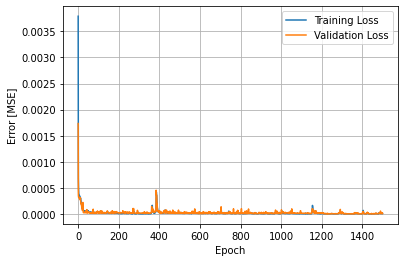

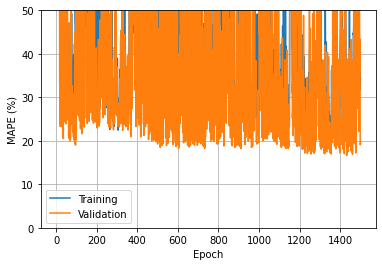

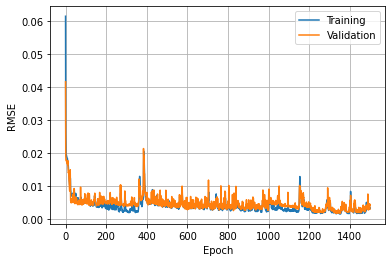

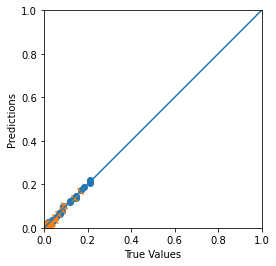

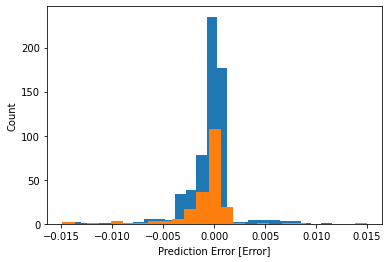

In [14]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

### 2nd-5th year CO2 Proxy - Gas Injection Phase

In [15]:
# Initialization before hyperparameter study
path_best_model = 'CO2_gas_proxy.keras'
path_best_model_performance = 'CO2_gas_proxy_performance.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = CO2_FgTf, CO2_FgTl, CO2_FgVf, CO2_FgVl

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 1, 5]

In [22]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate=%.6f
- number of hidden layers=%d
- number of nodes=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2]))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 1
Nodes: 5

loss: 0.03533784672617912

Learning rate: 2.1e-06
Dense layers: 2
Nodes: 3

loss: 0.06517007201910019

Learning rate: 4.4e-05
Dense layers: 3
Nodes: 10

loss: 0.002283336827531457

Learning rate: 1.9e-04
Dense layers: 3
Nodes: 4

loss: 0.001276155118830502

Learning rate: 9.4e-03
Dense layers: 1
Nodes: 18

loss: 0.00030646694358438253

Learning rate: 3.1e-06
Dense layers: 3
Nodes: 13

loss: 0.05324844270944595

Learning rate: 2.5e-03
Dense layers: 1
Nodes: 9

loss: 0.0006014577229507267

Learning rate: 1.7e-05
Dense layers: 1
Nodes: 8

loss: 0.020580651238560677

Learning rate: 5.6e-04
Dense layers: 2
Nodes: 18

loss: 0.00034562242217361927

Learning rate: 1.8e-04
Dense layers: 3
Nodes: 2

loss: 0.01975979097187519

Learning rate: 3.7e-03
Dense layers: 1
Nodes: 16
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping

loss: 0.00033076084218919277

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 2
Restoring mod

In [23]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.993795
R-square Validation: 0.985815
Training Average Absolute Error:
    - Maximum=0.039289
    - Mean=0.005638
    - Minimum=0.000014
Validation Average Absolute Error:
    - Maximum=0.048422
    - Mean=0.008318
    - Minimum=0.000017


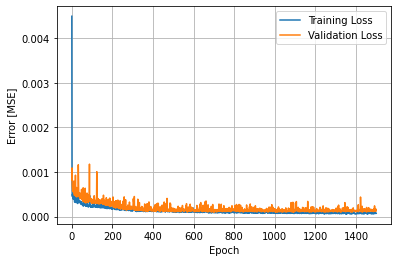

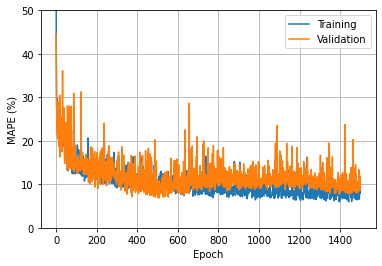

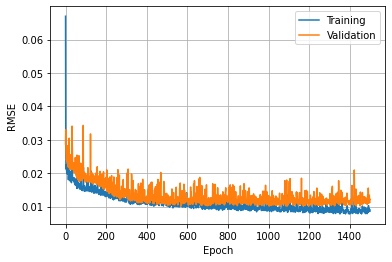

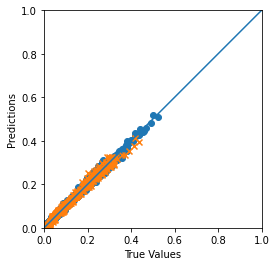

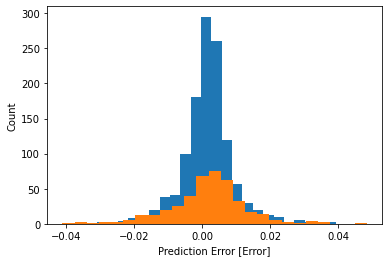

In [16]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

### 2nd-5th year CO2 Proxy - Water Injection Phase

In [17]:
# Initialization before hyperparameter study
path_best_model = 'CO2_wat_proxy.keras'
path_best_model_performance = 'CO2_wat_proxy_performance.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = CO2_FwTf, CO2_FwTl, CO2_FwVf, CO2_FwVl

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 1, 5]

In [26]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate=%.6f
- number of hidden layers=%d
- number of nodes=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2]))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 1
Nodes: 5

loss: 0.10620049387216568

Learning rate: 1.2e-05
Dense layers: 1
Nodes: 3

loss: 0.026393068954348564

Learning rate: 3.7e-04
Dense layers: 2
Nodes: 9

loss: 0.0014342297799885273

Learning rate: 1.9e-03
Dense layers: 2
Nodes: 4

loss: 0.001475794124417007

Learning rate: 3.7e-06
Dense layers: 2
Nodes: 19

loss: 0.018217012286186218

Learning rate: 8.3e-03
Dense layers: 2
Nodes: 9

loss: 0.0010836136061698198

Learning rate: 2.2e-03
Dense layers: 1
Nodes: 7

loss: 0.0013479995541274548

Learning rate: 3.8e-06
Dense layers: 3
Nodes: 12

loss: 0.07590606063604355

Learning rate: 5.3e-03
Dense layers: 2
Nodes: 5

loss: 0.0013263520086184144

Learning rate: 5.4e-04
Dense layers: 2
Nodes: 9

loss: 0.0012348046293482184

Learning rate: 9.6e-03
Dense layers: 2
Nodes: 11
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping

loss: 0.0011959481053054333

Learning rate: 1.0e-02
Dense layers: 2
Nodes: 10

loss: 0.0010

C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 3
Nodes: 20

loss: 0.0007965777185745537

Learning rate: 6.5e-04
Dense layers: 1
Nodes: 16

loss: 0.0013376390561461449

Learning rate: 5.9e-05
Dense layers: 3
Nodes: 17

loss: 0.0013157606590539217

Learning rate: 4.5e-06
Dense layers: 2
Nodes: 20

loss: 0.009389994665980339

Learning rate: 9.7e-05
Dense layers: 2
Nodes: 20

loss: 0.0012608845718204975

Learning rate: 7.6e-05
Dense layers: 1
Nodes: 2

loss: 0.07262701541185379

Learning rate: 4.1e-05
Dense layers: 3
Nodes: 20

loss: 0.0013288739137351513

Learning rate: 1.4e-04
Dense layers: 3
Nodes: 20

loss: 0.00133375299628824

Learning rate: 5.0e-05
Dense layers: 1
Nodes: 20

loss: 0.002095200354233384

Learning rate: 1.4e-05
Dense layers: 1
Nodes: 20

loss: 0.022456368431448936

Learning rate: 3.0e-05
Dense layers: 3
Nodes: 20

loss: 0.0019518822664394975

Learning rate: 3.4e-05
Dense layers: 3
Nodes: 2

loss: 0.005673254374414682

Learning rate: 6.9e-05
Dense layers: 3
Nodes: 20

loss: 0.0012

In [27]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.989211
R-square Validation: 0.967928
Training Average Absolute Error:
    - Maximum=0.075708
    - Mean=0.010262
    - Minimum=0.000004
Validation Average Absolute Error:
    - Maximum=0.110483
    - Mean=0.017028
    - Minimum=0.000023


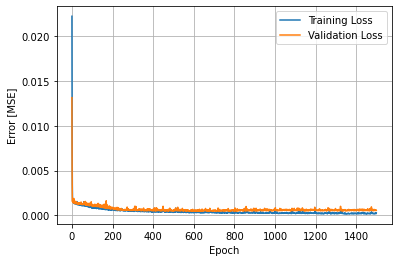

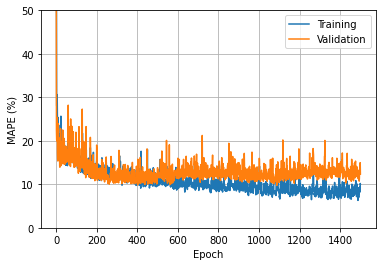

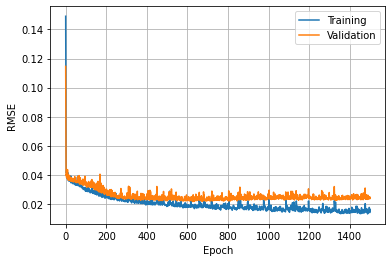

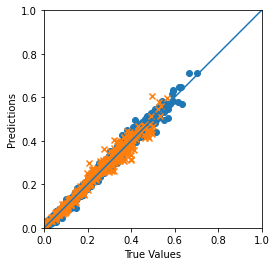

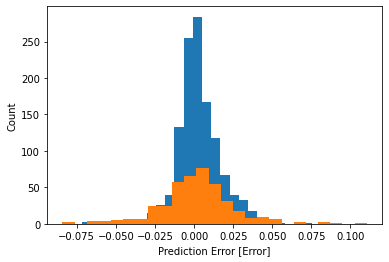

In [18]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

### 5th to 10th year CO2 Proxy - Gas Injection Phase

In [19]:
# Initialization before hyperparameter study
path_best_model = 'CO2_gas_proxy2.keras'
path_best_model_performance = 'CO2_gas_proxy_performance2.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = CO2_FgTf2, CO2_FgTl2, CO2_FgVf2, CO2_FgVl2

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 1, 5]

In [22]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate=%.6f
- number of hidden layers=%d
- number of nodes=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2]))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 1
Nodes: 5

loss: 0.03533784672617912

Learning rate: 2.1e-06
Dense layers: 2
Nodes: 3

loss: 0.06517007201910019

Learning rate: 4.4e-05
Dense layers: 3
Nodes: 10

loss: 0.002283336827531457

Learning rate: 1.9e-04
Dense layers: 3
Nodes: 4

loss: 0.001276155118830502

Learning rate: 9.4e-03
Dense layers: 1
Nodes: 18

loss: 0.00030646694358438253

Learning rate: 3.1e-06
Dense layers: 3
Nodes: 13

loss: 0.05324844270944595

Learning rate: 2.5e-03
Dense layers: 1
Nodes: 9

loss: 0.0006014577229507267

Learning rate: 1.7e-05
Dense layers: 1
Nodes: 8

loss: 0.020580651238560677

Learning rate: 5.6e-04
Dense layers: 2
Nodes: 18

loss: 0.00034562242217361927

Learning rate: 1.8e-04
Dense layers: 3
Nodes: 2

loss: 0.01975979097187519

Learning rate: 3.7e-03
Dense layers: 1
Nodes: 16
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping

loss: 0.00033076084218919277

Learning rate: 1.0e-02
Dense layers: 3
Nodes: 2
Restoring mod

In [23]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.991677
R-square Validation: 0.969537
Training Average Absolute Error:
    - Maximum=0.054704
    - Mean=0.008512
    - Minimum=0.000002
Validation Average Absolute Error:
    - Maximum=0.064732
    - Mean=0.012451
    - Minimum=0.000042


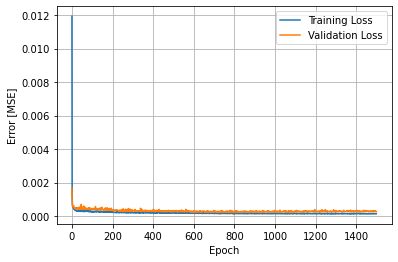

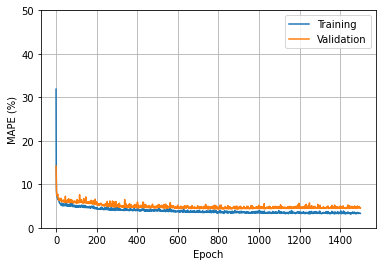

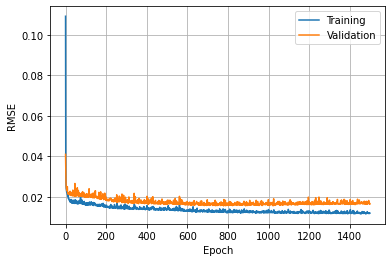

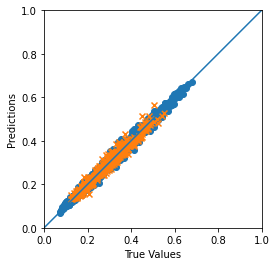

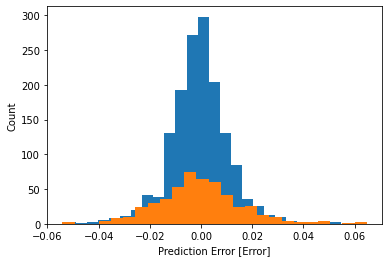

In [20]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

### 5th to 10th year CO2 Proxy - Water Injection Phase

In [21]:
# Initialization before hyperparameter study
path_best_model = 'CO2_wat_proxy2.keras'
path_best_model_performance = 'CO2_wat_proxy_performance2.json'
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = CO2_FwTf2, CO2_FwTl2, CO2_FwVf2, CO2_FwVl2

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 1, 5]

In [26]:
import time

start = time.time()

search_result = gp_minimize(func=ANN_study,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,
                            x0=default_parameters)

print("""Best parameters:
- learning rate=%.6f
- number of hidden layers=%d
- number of nodes=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2]))

end = time.time()
total_time = (end-start)/60
print("Total time = {:.2f} minutes".format(total_time))

Learning rate: 1.0e-05
Dense layers: 1
Nodes: 5

loss: 0.10620049387216568

Learning rate: 1.2e-05
Dense layers: 1
Nodes: 3

loss: 0.026393068954348564

Learning rate: 3.7e-04
Dense layers: 2
Nodes: 9

loss: 0.0014342297799885273

Learning rate: 1.9e-03
Dense layers: 2
Nodes: 4

loss: 0.001475794124417007

Learning rate: 3.7e-06
Dense layers: 2
Nodes: 19

loss: 0.018217012286186218

Learning rate: 8.3e-03
Dense layers: 2
Nodes: 9

loss: 0.0010836136061698198

Learning rate: 2.2e-03
Dense layers: 1
Nodes: 7

loss: 0.0013479995541274548

Learning rate: 3.8e-06
Dense layers: 3
Nodes: 12

loss: 0.07590606063604355

Learning rate: 5.3e-03
Dense layers: 2
Nodes: 5

loss: 0.0013263520086184144

Learning rate: 5.4e-04
Dense layers: 2
Nodes: 9

loss: 0.0012348046293482184

Learning rate: 9.6e-03
Dense layers: 2
Nodes: 11
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping

loss: 0.0011959481053054333

Learning rate: 1.0e-02
Dense layers: 2
Nodes: 10

loss: 0.0010

C:\Users\Aqnan Matthew\anaconda3\envs\thesis\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Learning rate: 1.0e-02
Dense layers: 3
Nodes: 20

loss: 0.0007965777185745537

Learning rate: 6.5e-04
Dense layers: 1
Nodes: 16

loss: 0.0013376390561461449

Learning rate: 5.9e-05
Dense layers: 3
Nodes: 17

loss: 0.0013157606590539217

Learning rate: 4.5e-06
Dense layers: 2
Nodes: 20

loss: 0.009389994665980339

Learning rate: 9.7e-05
Dense layers: 2
Nodes: 20

loss: 0.0012608845718204975

Learning rate: 7.6e-05
Dense layers: 1
Nodes: 2

loss: 0.07262701541185379

Learning rate: 4.1e-05
Dense layers: 3
Nodes: 20

loss: 0.0013288739137351513

Learning rate: 1.4e-04
Dense layers: 3
Nodes: 20

loss: 0.00133375299628824

Learning rate: 5.0e-05
Dense layers: 1
Nodes: 20

loss: 0.002095200354233384

Learning rate: 1.4e-05
Dense layers: 1
Nodes: 20

loss: 0.022456368431448936

Learning rate: 3.0e-05
Dense layers: 3
Nodes: 20

loss: 0.0019518822664394975

Learning rate: 3.4e-05
Dense layers: 3
Nodes: 2

loss: 0.005673254374414682

Learning rate: 6.9e-05
Dense layers: 3
Nodes: 20

loss: 0.0012

In [27]:
# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

R-square Training: 0.980850
R-square Validation: 0.957805
Training Average Absolute Error:
    - Maximum=0.144688
    - Mean=0.013972
    - Minimum=0.000000
Validation Average Absolute Error:
    - Maximum=0.118840
    - Mean=0.021420
    - Minimum=0.000049


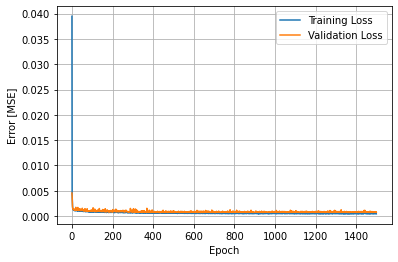

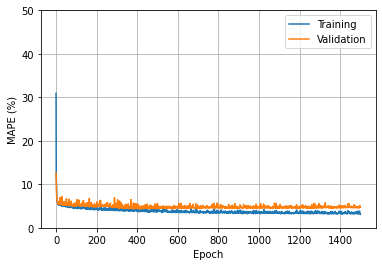

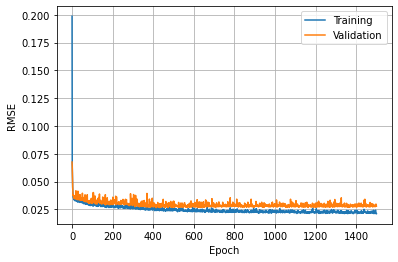

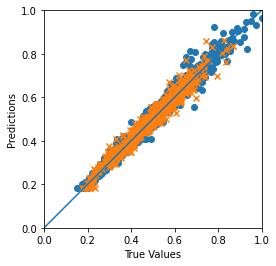

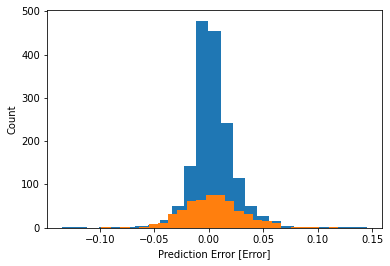

In [22]:
# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

plot_error_acc(best_model_performance)

lims = [0,1]
plot_train_performance(best_model, features, target, val_features, val_target, lims)

## Run the whole data using combined proxy model (Training, Validation, Blind Test)
In this section, 10 blind tests are prepared.

In [9]:
# Importing database
blind_proxy_database = pd.read_excel('EggModel_blind.xlsx')

#### Simple 1 run, Choose Case ID to be tested in Blind Test
Range 1- 68 --> Trained data <br>
Range 69 - 78 --> Blind Test data

In [10]:
# Put Case ID here
Case_ID=59

blind_database = blind_proxy_database[blind_proxy_database['Case'] == Case_ID].reset_index()

# Making dataset comparison for FOPR proxy
FOPR_blind_label = blind_database['FOPR [sm3/d]'].to_numpy()

# Making dataset comparison for FCO2PR proxy
CO2_blind_label = blind_database['FCO2PR [kg-mole/d]'].to_numpy()

# Loading the proxy
fopr_gas_model = load_model('FOPR_gas_proxy.keras')
fopr_wat_model = load_model('FOPR_wat_proxy.keras')
co2_1_model = load_model('CO2_1_proxy.keras')
co2_gas_model = load_model('CO2_gas_proxy.keras')
co2_wat_model = load_model('CO2_wat_proxy.keras')
co2_gas_model2 = load_model('CO2_gas_proxy2.keras')
co2_wat_model2 = load_model('CO2_wat_proxy2.keras')

Running the proxies

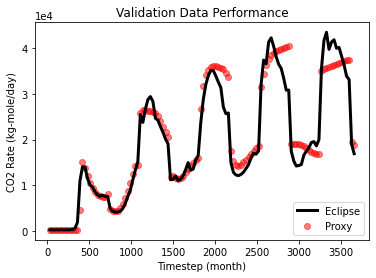

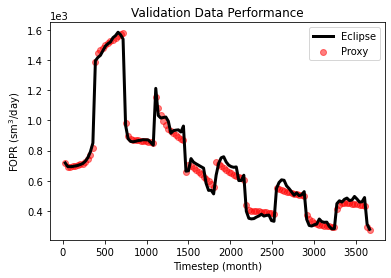

In [14]:
# Defining temporary storage and variables
ts = 1
proxy_result = np.empty(shape=(1,5))
FOPR_before = 0.513797246
CO2_before = 0.00515003

# Taking the blind test condition
halfcycle_blind = blind_database['Halfcycle day'][0]
qg_blind = blind_database['qgtot'][0]
qw_blind = blind_database['qwtot'][0]

# Looping through 122 timesteps
for ts in range (1, 123):
    ts_norm = (ts-1)/(122-1)
    CO2_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, CO2_before]])
    FOPR_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, FOPR_before]])
    
    # Determine whether to use gas or water proxy
    temp = math.floor((ts-1)/(halfcycle_blind*9+3))
    if (temp % 2) == 0:
        if ts <= 12:
            CO2 = co2_1_model.predict(CO2_input)
        elif ts <= 60:
            CO2 = co2_gas_model.predict(CO2_input)
        else:
            CO2 = co2_gas_model2.predict(CO2_input)
        FOPR = fopr_gas_model.predict(FOPR_input)
    else:
        if ts <= 12:
            CO2 = co2_1_model.predict(CO2_input)
        elif ts <= 60:
            CO2 = co2_wat_model.predict(CO2_input)
        else:
            CO2 = co2_wat_model2.predict(CO2_input)
        FOPR = fopr_wat_model.predict(FOPR_input)
    
    # transfer value from array to one value
    FOPR = FOPR[0,0]
    CO2 = CO2[0,0]
    
    result = np.array([[ts_norm, CO2_before, CO2, FOPR_before, FOPR]])
    proxy_result = np.append(proxy_result, result, axis = 0)
    
    CO2_before = CO2
    FOPR_before = FOPR
        
# Throwing dummy value in index 0
proxy_result = proxy_result[1:,:]

# Plotting the result
real_timestep = proxy_result[:,0]*(3660-30)+30
real_CO2_eclipse = CO2_blind_label[:]*(59843.74609+0)+0
real_CO2_proxy = proxy_result[:,2]*(59843.74609+0)+0
real_FOPR_eclipse = FOPR_blind_label[:]*(2026.886719-0)+0
real_FOPR_proxy = proxy_result[:,4]*(2026.886719-0)+0

plt.figure(20)
if Case_ID > 68:
    plt.title('Blind Test Performance')
elif Case_ID in val_case:
    plt.title('Validation Data Performance')
else:
    plt.title('Training Data Performance')
plt.xlabel('Timestep (month)')
plt.ylabel('CO2 Rate (kg-mole/day)')
plt.plot(real_timestep[:], real_CO2_eclipse[:], label='Eclipse', color='black', linewidth=3)
plt.scatter(real_timestep[:], real_CO2_proxy[:], label='Proxy', linestyle='-', color='red', alpha=0.5)
plt.legend(['Eclipse', 'Proxy'], loc='lower right')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

plt.figure(21)
if Case_ID > 68:
    plt.title('Blind Test Performance')
elif Case_ID in val_case:
    plt.title('Validation Data Performance')
else:
    plt.title('Training Data Performance')
plt.xlabel('Timestep (month)')
plt.ylabel('FOPR (sm$^3$/day)')
plt.plot(real_timestep[:], real_FOPR_eclipse[:], label='Eclipse', color='black', linewidth=3)
plt.scatter(real_timestep[:], real_FOPR_proxy[:], label='Proxy', linestyle='-', color='red', alpha=0.5)
plt.legend(['Eclipse', 'Proxy'], loc='upper right')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

## Run all data
All data that we have in the database (Training, Validation, Blind Test)

In [28]:
proxy_result = np.empty(shape=(1,3))

for Case_ID in range (1,81):
    blind_database = blind_proxy_database[blind_proxy_database['Case'] == Case_ID].reset_index()

    # Making dataset for FOPR proxy
    FOPR_blind_label = blind_database['FOPR [sm3/d]'].to_numpy()

    # Making dataset for FCO2PR proxy
    CO2_blind_label = blind_database['FCO2PR [kg-mole/d]'].to_numpy()
        
    # Defining temporary storage and variables
    ts = 1
    FOPR_before = 0.513797246
    CO2_before = 0.00515003

    # Taking the blind test condition
    halfcycle_blind = blind_database['Halfcycle day'][0]
    qg_blind = blind_database['qgtot'][0]
    qw_blind = blind_database['qwtot'][0]

    # Looping through 122 timesteps
    for ts in range (1, 123):
        ts_norm = (ts-1)/(122-1)
        CO2_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, CO2_before]])
        FOPR_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, FOPR_before]])

        # Determine whether to use gas or water proxy
        temp = math.floor((ts-1)/(halfcycle_blind*9+3))
        if (temp % 2) == 0:
            if ts <= 12:
                CO2 = co2_1_model.predict(CO2_input)
            elif ts <= 60:
                CO2 = co2_gas_model.predict(CO2_input)
            else:
                CO2 = co2_gas_model2.predict(CO2_input)
            FOPR = fopr_gas_model.predict(FOPR_input)
        else:
            if ts <= 12:
                CO2 = co2_1_model.predict(CO2_input)
            elif ts <= 60:
                CO2 = co2_wat_model.predict(CO2_input)
            else:
                CO2 = co2_wat_model2.predict(CO2_input)
            FOPR = fopr_wat_model.predict(FOPR_input)

        # transfer value from array to one value
        FOPR = FOPR[0,0]
        CO2 = CO2[0,0]
        
        # Denormalization
        ts_real = ts_norm*(3660-30)+30
        real_CO2_proxy = CO2*(59843.74609+0)+0
        real_FOPR_proxy = FOPR*(2026.886719-0)+0
        
        result = np.array([[ts_real, real_CO2_proxy, real_FOPR_proxy]])
        proxy_result = np.append(proxy_result, result, axis = 0)

        CO2_before = CO2
        FOPR_before = FOPR

# Throwing dummy value in index 0
proxy_result = proxy_result[1:,:]

ProxyResult = pd.DataFrame(proxy_result, columns=['Timestep', 'CO2 Proxy', 'FOPR Proxy'])

ProxyResult.to_excel("ProxyAllRun.xlsx",sheet_name='RunResults')

# Optimization Study
Performing optimization study using the proxy

In [11]:
# Defined proxy as function
def oilproxy (halfcycle,qg,qw):
    #Normalization
    halfcycle_norm = (halfcycle-3)/(12-3)
    qg_norm = (qg-1)/(2-1)
    qw_norm = (qw-3000)/(9000-3000)

    # Defining temporary storage and variables
    ts = 1
    proxy_result = np.empty(shape=(1,2))
    FOPR_before = 0.513797246

    # Looping through 122 timesteps
    for ts in range (1, 123):
        ts_norm = (ts-1)/(122-1)
        FOPR_input = np.array([[halfcycle_norm, qg_norm, qw_norm, ts_norm, FOPR_before]])

        # Determine whether to use gas or water proxy
        temp = math.floor((ts-1)/(halfcycle_norm*9+3))
        if (temp % 2) == 0:
            FOPR = fopr_gas_model.predict(FOPR_input)
        else:
            FOPR = fopr_wat_model.predict(FOPR_input)

        # transfer value from array to one value
        FOPR = FOPR[0,0]
        result = np.array([[ts_norm, FOPR]])
        proxy_result = np.append(proxy_result, result, axis = 0)
        FOPR_before = FOPR

    # Throwing dummy value in index 0
    proxy_result = proxy_result[1:,:]

    # Plotting the result
    FOPT_time = (proxy_result[:,1]*(2026.886719-0)+0)*30
    FOPT = np.sum(FOPT_time)
    
    return FOPT

def co2proxy1 (halfcycle,qg,qw):
    #Normalization
    halfcycle_norm = (halfcycle-3)/(12-3)
    qg_norm = (qg-1)/(2-1)
    qw_norm = (qw-3000)/(9000-3000)

    # Defining temporary storage and variables
    ts = 1
    proxy_result = np.empty(shape=(1,2))
    CO2_before = 0.00515003

    # Looping through 122 timesteps
    for ts in range (1, 123):
        ts_norm = (ts-1)/(122-1)
        CO2_input = np.array([[halfcycle_norm, qg_norm, qw_norm, ts_norm, CO2_before]])

        # Determine whether to use gas or water proxy
        temp = math.floor((ts-1)/(halfcycle_norm*9+3))
        if (temp % 2) == 0:
            if ts <= 12:
                CO2 = co2_1_model.predict(CO2_input)
            elif ts <= 60:
                CO2 = co2_gas_model.predict(CO2_input)
            else:
                CO2 = co2_gas_model2.predict(CO2_input)
        else:
            if ts <= 12:
                CO2 = co2_1_model.predict(CO2_input)
            elif ts <= 60:
                CO2 = co2_wat_model.predict(CO2_input)
            else:
                CO2 = co2_wat_model2.predict(CO2_input)

        # transfer value from array to one value
        CO2 = CO2[0,0]
        result = np.array([[ts_norm, CO2]])
        proxy_result = np.append(proxy_result, result, axis = 0)
        CO2_before = CO2

    # Throwing dummy value in index 0
    proxy_result = proxy_result[1:,:]

    # Denormalization
    FCO2PT_time = (proxy_result[:,1]*(59843.74609+0)+0)*30
    FCO2PT = np.sum(FCO2PT_time)
    
    return FCO2PT

def CO2proxy(halfcycle,qg,qw):
    time1 = math.floor(122 / (2 * halfcycle))
    time2 = 122%(2 * halfcycle)
    if math.floor(time2 / halfcycle)==0:
        gas_time = time1 * halfcycle + time2
    else:
        gas_time = time1 * halfcycle + halfcycle
    
    ## units in Msm3
    sequestrated_co2 = gas_time * qg * 30 - co2proxy1(halfcycle,qg,qw)/42221
    return sequestrated_co2

#### Performing optimization study using NSGA-II

In [33]:
# Define problem
import time
import numpy as np
start_time = time.time()

from pymoo.model.problem import FunctionalProblem

objs = [
    lambda x : -oilproxy(x[0],x[1],x[2]),
    lambda x : -CO2proxy(x[0],x[1],x[2])    
]

constr_ieq = [
    lambda x : x[0]%3
]

functional_problem = FunctionalProblem(3,
                                       objs,
                                       constr_ieq=constr_ieq,
                                       xl=np.array([3,1,3000]),
                                       xu=np.array([12,2,9000]))

# Defining the integer and real value
mask = ["int", "real", "real"]

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=3.0),
    "int": get_mutation("int_pm", eta=3.0)
})

# test_problem = MyProblem()
problem = functional_problem

# Optimization Algorithm
from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True
)

# Define termination criterion
from pymoo.factory import get_termination

termination = get_termination("n_gen", 100)

# Perform Optimization study
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end_time = time.time()
total_time = end_time-start_time

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      40 |  0.00000E+00 |  0.775000000 |       5 |            - |            -
    2 |      50 |  0.00000E+00 |  0.575000000 |       6 |  0.007782724 |        ideal
    3 |      60 |  0.00000E+00 |  0.300000000 |       8 |  0.033729761 |            f
    4 |      70 |  0.00000E+00 |  0.250000000 |       8 |  0.032022652 |            f
    5 |      80 |  0.00000E+00 |  0.050000000 |      10 |  0.031172981 |        ideal
    6 |      90 |  0.00000E+00 |  0.00000E+00 |      10 |  0.005831775 |            f
    7 |     100 |  0.00000E+00 |  0.00000E+00 |       8 |  0.134816773 |        ideal
    8 |     110 |  0.00000E+00 |  0.00000E+00 |       8 |  0.00000E+00 |            f
    9 |     120 |  0.00000E+00 |  0.00000E+00 |       8 |  0.00000E+00 |            f
   10 |     130 |  0.00000E+00 |  0.00000E+00 |       9 |  0.017726890 |            f
   11 |     140 |  0.00000E+00 |  0.00000E+00 |      1

   94 |     970 |  0.00000E+00 |  0.00000E+00 |      40 |  0.00000E+00 |            f
   95 |     980 |  0.00000E+00 |  0.00000E+00 |      40 |  0.000015529 |            f
   96 |     990 |  0.00000E+00 |  0.00000E+00 |      40 |  0.000482812 |            f
   97 |    1000 |  0.00000E+00 |  0.00000E+00 |      40 |  0.00000E+00 |            f
   98 |    1010 |  0.00000E+00 |  0.00000E+00 |      40 |  0.000964328 |            f
   99 |    1020 |  0.00000E+00 |  0.00000E+00 |      40 |  0.000211263 |            f
  100 |    1030 |  0.00000E+00 |  0.00000E+00 |      40 |  9.58083E-07 |            f


### Assessing the pareto optimum results

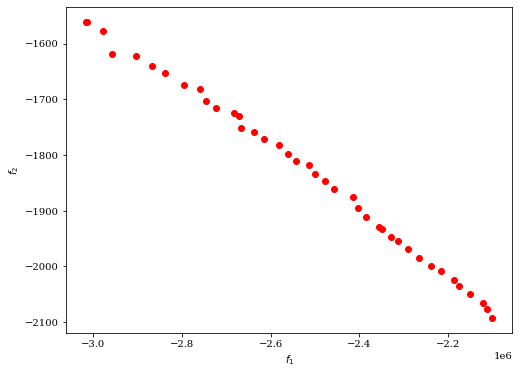

In [35]:
from pymoo.visualization.scatter import Scatter
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

In [36]:
res.X

array([[3, 1.9998293463795025, 3001.1723680756295],
       [3, 1.9936423285866645, 8996.274706170807],
       [3, 1.9999688405414644, 8696.176560284526],
       [6, 1.999538424443133, 8999.051341991131],
       [6, 1.9999010493476244, 7845.561704700514],
       [6, 1.9889090814294281, 8695.202447273512],
       [6, 1.9975808512336837, 8199.963273507792],
       [3, 1.9993234390113488, 5252.219242584031],
       [3, 1.9827115977975027, 5061.793281372774],
       [3, 1.9991084337790022, 3409.4126986387123],
       [3, 1.9988424776544322, 4921.257433260977],
       [3, 1.9977294579107372, 5924.005912982754],
       [6, 1.9933317851705095, 7231.23342887501],
       [3, 1.998533097173807, 4489.378512168959],
       [9, 1.9980468016892916, 6554.575598146427],
       [3, 1.9974373249509711, 4022.821731980152],
       [3, 1.9975535188158227, 5360.052969692479],
       [3, 1.9986727098430976, 5793.001823013208],
       [3, 1.9969279867831022, 5007.011103621888],
       [3, 1.9966644035190115, 3

In [37]:
res.F

array([[-2.10038089e+06, -2.09284094e+03],
       [-3.01609992e+06, -1.56066530e+03],
       [-2.97801839e+06, -1.57673468e+03],
       [-2.95707406e+06, -1.61896746e+03],
       [-2.79587634e+06, -1.67469952e+03],
       [-2.90442131e+06, -1.62314850e+03],
       [-2.83758751e+06, -1.65220462e+03],
       [-2.45649855e+06, -1.86129724e+03],
       [-2.41417126e+06, -1.87603909e+03],
       [-2.15104023e+06, -2.05021432e+03],
       [-2.38461276e+06, -1.91082763e+03],
       [-2.58146560e+06, -1.78156107e+03],
       [-2.72360858e+06, -1.71495443e+03],
       [-2.28994943e+06, -1.96858701e+03],
       [-2.61470247e+06, -1.77123067e+03],
       [-2.21659339e+06, -2.00788820e+03],
       [-2.47718731e+06, -1.84658964e+03],
       [-2.56078144e+06, -1.79786996e+03],
       [-2.40344775e+06, -1.89576262e+03],
       [-2.18610894e+06, -2.02441122e+03],
       [-2.23775166e+06, -1.99842772e+03],
       [-2.63852258e+06, -1.75835332e+03],
       [-2.50114426e+06, -1.83363805e+03],
       [-2.